In [ ]:
# -*- coding: utf-8 -*-
"""
Heart Disease Prediction System using Hybrid Deep Learning Model

This notebook combines tabular data, synthetic ECG images, and sequential data
to predict heart disease presence (binary classification).

Key steps:
1. Load and preprocess the Cleveland Heart Disease dataset
2. Create synthetic ECG images from tabular data
3. Convert tabular data to sequences for LSTM
4. Build a hybrid model combining:
   - Tabular data processing (Dense layers)
   - Sequential data processing (LSTM)
   - Image data processing (CNN + VGG16)
5. Train and evaluate the model
"""

# Import necessary libraries
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D,
                                    LSTM, Bidirectional, Flatten,
                                    Dropout, concatenate)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Download the heart disease dataset from UCI repository
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Define meaningful column names for the dataset
heart_data_columns = [
    'age', 'gender', 'chest_pain_type', 'resting_blood_pressure',
    'cholesterol', 'fasting_blood_sugar', 'resting_ecg',
    'max_heart_rate', 'exercise_induced_angina', 'st_depression',
    'st_slope', 'num_major_vessels', 'thalassemia', 'heart_disease'
]

# Load the data into a pandas DataFrame
heart_data = pd.read_csv(dataset_url, names=heart_data_columns, na_values='?')

# Data cleaning - remove rows with missing values
heart_data = heart_data.dropna()

# Convert target to binary (0 = no disease, 1 = some form of heart disease)
heart_data['heart_disease'] = heart_data['heart_disease'].apply(
    lambda x: 1 if x > 0 else 0
)

# Show the first few rows of our cleaned dataset
print("First few rows of the heart disease dataset:")
heart_data.head()

First few rows of the heart disease dataset:


,age,gender,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
# Separate features (X) and target (y)
features = heart_data.drop('heart_disease', axis=1)
target = heart_data['heart_disease']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    random_state=42,
    stratify=target  # Keep same proportion of cases in both sets
)

# Identify numerical columns to scale (normalize)
numerical_columns = [
    'age', 'resting_blood_pressure', 'cholesterol',
    'max_heart_rate', 'st_depression'
]

# Scale numerical features to have mean=0 and std=1
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Convert to numpy arrays for model training
X_train_tabular = X_train.values
X_test_tabular = X_test.values
y_train = y_train.values
y_test = y_test.values

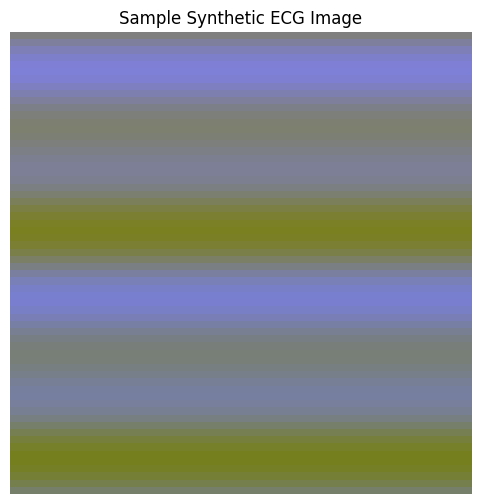

In [ ]:
def generate_ecg_images(patient_data):
    """
    Create synthetic ECG-like images from patient data

    Parameters:
    - patient_data: numpy array of patient features

    Returns:
    - Normalized RGB images (64x64 pixels) simulating ECG patterns
    """
    num_patients = patient_data.shape[0]
    ecg_images = np.zeros((num_patients, 64, 64, 3))  # 64x64 RGB images

    for patient_idx in range(num_patients):
        patient_features = patient_data[patient_idx]

        # Create x-axis values (time points)
        time_points = np.linspace(0, 2*np.pi, 64)

        # Channel 1 (Red): Heart rate and blood pressure pattern
        heart_rate_pattern = np.sin(time_points*patient_features[7]/100) * 0.5
        bp_pattern = np.sin(time_points*patient_features[3]/50) * 0.3
        combined_pattern_1 = heart_rate_pattern + bp_pattern

        # Channel 2 (Green): Cholesterol and age pattern
        cholesterol_pattern = np.sin(time_points*patient_features[4]/200) * 0.6
        age_pattern = np.sin(time_points*patient_features[0]/50) * 0.2
        combined_pattern_2 = cholesterol_pattern + age_pattern

        # Channel 3 (Blue): Exercise and ST depression pattern
        exercise_pattern = np.sin(time_points*(patient_features[8]+1)*2) * 0.4
        st_depression_pattern = np.sin(time_points*patient_features[9]*2) * 0.4
        combined_pattern_3 = exercise_pattern + st_depression_pattern

        # Create the image by scaling values to 0-255 then normalizing
        for pixel_idx in range(64):
            ecg_images[patient_idx, pixel_idx, :, 0] = (combined_pattern_1[pixel_idx] + 1) * 127  # Red
            ecg_images[patient_idx, pixel_idx, :, 1] = (combined_pattern_2[pixel_idx] + 1) * 127  # Green
            ecg_images[patient_idx, pixel_idx, :, 2] = (combined_pattern_3[pixel_idx] + 1) * 127  # Blue

    return ecg_images / 255.0  # Normalize to 0-1 range

# Generate synthetic ECG images for training and testing
train_ecg_images = generate_ecg_images(X_train_tabular)
test_ecg_images = generate_ecg_images(X_test_tabular)

# Visualize a sample ECG image
plt.figure(figsize=(6, 6))
plt.title("Sample Synthetic ECG Image")
plt.imshow(train_ecg_images[0])
plt.axis('off')
plt.show()

In [ ]:
def create_patient_sequences(patient_data, sequence_length=5):
    """
    Convert patient data into sequences with slight variations

    Parameters:
    - patient_data: numpy array of patient features
    - sequence_length: how many time steps to create

    Returns:
    - Sequences of patient data with minor random variations
    """
    num_patients = patient_data.shape[0]
    num_features = patient_data.shape[1]
    patient_sequences = np.zeros((num_patients, sequence_length, num_features))

    for patient_idx in range(num_patients):
        for time_step in range(sequence_length):
            # Add slight random variation (10% noise) to original data
            patient_sequences[patient_idx, time_step, :] = (
                patient_data[patient_idx, :] * (0.9 + 0.1*np.random.rand())
            )

    return patient_sequences

# Create sequences for training and testing
train_patient_sequences = create_patient_sequences(X_train_tabular)
test_patient_sequences = create_patient_sequences(X_test_tabular)

In [ ]:
def create_hybrid_model(tabular_shape, sequence_shape, image_shape):
    """
    Build a hybrid model combining different data types

    Parameters:
    - tabular_shape: shape of the tabular data
    - sequence_shape: shape of the sequence data
    - image_shape: shape of the ECG images

    Returns:
    - Compiled Keras model ready for training
    """

    # --- 1. Tabular Data Branch ---
    tabular_input = Input(shape=tabular_shape, name='tabular_input')
    tabular_features = Dense(64, activation='relu')(tabular_input)
    tabular_features = Dropout(0.3)(tabular_features)  # Prevent overfitting
    tabular_features = Dense(32, activation='relu')(tabular_features)
    tabular_branch = Model(inputs=tabular_input, outputs=tabular_features)

    # --- 2. Sequence Data Branch ---
    sequence_input = Input(shape=sequence_shape, name='sequence_input')
    sequence_features = Bidirectional(LSTM(32, return_sequences=True))(sequence_input)
    sequence_features = Dropout(0.2)(sequence_features)
    sequence_features = Bidirectional(LSTM(16))(sequence_features)
    sequence_branch = Model(inputs=sequence_input, outputs=sequence_features)

    # --- 3. Simple CNN Image Branch ---
    image_input = Input(shape=image_shape, name='image_input')
    # First convolution layer
    img_features = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(image_input)
    img_features = MaxPooling2D(pool_size=(2,2))(img_features)
    # Second convolution layer
    img_features = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(img_features)
    img_features = MaxPooling2D(pool_size=(2,2))(img_features)
    # Flatten and dense layer
    img_features = Flatten()(img_features)
    img_features = Dense(64, activation='relu')(img_features)
    cnn_branch = Model(inputs=image_input, outputs=img_features)

    # --- 4. Pretrained VGG16 Image Branch ---
    # Load VGG16 with pretrained weights (trained on ImageNet)
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
    # Freeze VGG16 layers so we don't retrain them
    for layer in vgg_model.layers:
        layer.trainable = False
    # Add custom layers on top
    vgg_features = vgg_model(image_input)
    vgg_features = Flatten()(vgg_features)
    vgg_features = Dense(128, activation='relu')(vgg_features)
    vgg_branch = Model(inputs=image_input, outputs=vgg_features)

    # --- Combine All Branches ---
    combined_features = concatenate([
        tabular_branch(tabular_input),
        sequence_branch(sequence_input),
        cnn_branch(image_input),
        vgg_branch(image_input)
    ])

    # --- Final Classification Layers ---
    x = Dropout(0.5)(combined_features)  # Strong dropout to prevent overfitting
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create the complete model
    model = Model(
        inputs=[tabular_input, sequence_input, image_input],
        outputs=output
    )

    # Compile with Adam optimizer and binary crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define input shapes for our model
tabular_input_shape = (X_train_tabular.shape[1],)
sequence_input_shape = (train_patient_sequences.shape[1], train_patient_sequences.shape[2])
image_input_shape = (64, 64, 3)

# Create and display the model
heart_disease_model = create_hybrid_model(
    tabular_input_shape,
    sequence_input_shape,
    image_input_shape
)

# Show model architecture
heart_disease_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_input      │ (None, 5, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 32)        │      2,976 │ tabular_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 32)        │     22,144 │ sequence_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 64)        │    822,272 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 128)       │ 14,976,960 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional_1[0][… │
│                     │                   │            │ functional_2[0][… │
│                     │                   │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,840,865 (60.43 MB)

 Trainable params: 1,126,177 (4.30 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model for 30 epochs
training_history = heart_disease_model.fit(
    [X_train_tabular, train_patient_sequences, train_ecg_images],
    y_train,
    validation_data=([X_test_tabular, test_patient_sequences, test_ecg_images], y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate model performance on test set
test_loss, test_accuracy = heart_disease_model.evaluate(
    [X_test_tabular, test_patient_sequences, test_ecg_images],
    y_test,
    verbose=0
)

print(f"\nFinal Test Accuracy: {test_accuracy*100:.2f}%")

# Calculate F1 score (balance between precision and recall)
test_predictions = heart_disease_model.predict(
    [X_test_tabular, test_patient_sequences, test_ecg_images]
)
test_predictions = (test_predictions > 0.5).astype(int)
test_f1 = f1_score(y_test, test_predictions)
print(f"Test F1 Score: {test_f1*100:.2f}%")

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.5436 - loss: 0.7427 - val_accuracy: 0.7667 - val_loss: 0.5731
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6362 - loss: 0.6409 - val_accuracy: 0.8333 - val_loss: 0.5151
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6628 - loss: 0.6196 - val_accuracy: 0.7833 - val_loss: 0.4973
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7900 - loss: 0.4914 - val_accuracy: 0.8167 - val_loss: 0.4641
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7506 - loss: 0.5235 - val_accuracy: 0.8167 - val_loss: 0.4241
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7082 - loss: 0.5370 - val_accuracy: 0.8333 - val_loss: 0.4007
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7691 - loss: 0.4804 - val_accuracy: 0.8667 - val_loss: 0.3809
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7812 - loss: 0.4914 - val_accuracy: 0.8500 - val_loss: 0.371

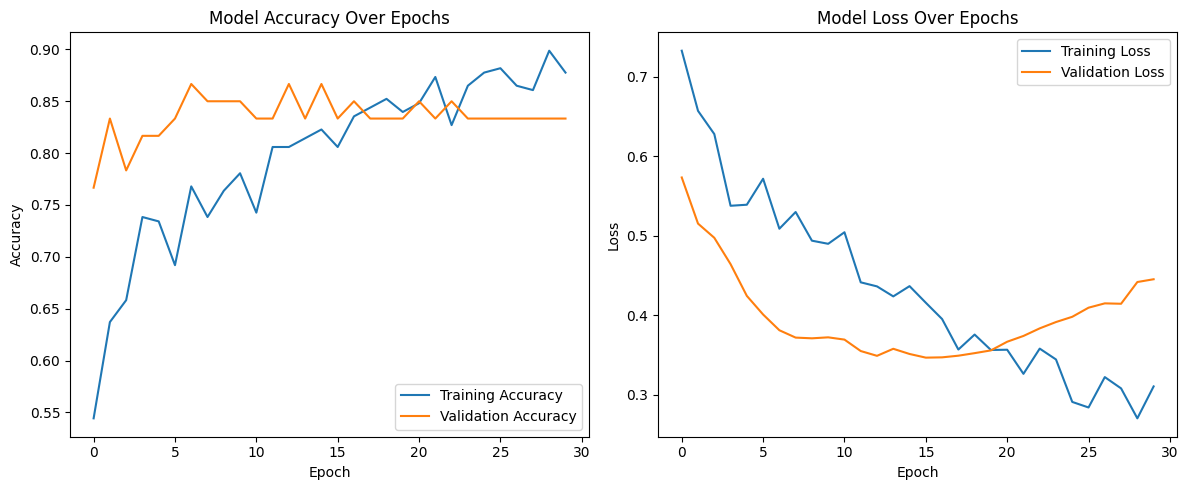


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.82      0.82      0.82        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



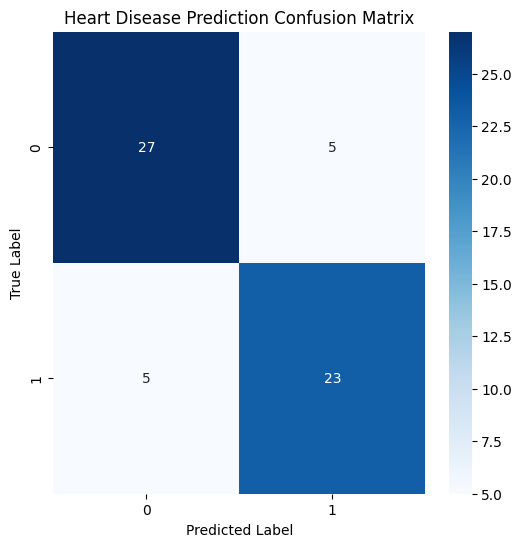

In [ ]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Generate classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_predictions))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Heart Disease Prediction Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model_path = '/content/heart_disease_model.h5'  # .h5 is the standard format
heart_disease_model.save(model_path)
print("✅ Model saved to Colab's storage at:", model_path)

✅ Model saved to Colab's storage at: /content/heart_disease_model.h5


In [ ]:
from google.colab import files

# Trigger browser download
files.download(model_path)
print("\n⬇️ Check your browser downloads for 'heart_disease_model.h5'!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Check your browser downloads for 'heart_disease_model.h5'!
